### Can tidal forces and the Lidov-Kozai mechanism cause a system of exomoons to align in the same orbital plane?

This script creates a system of the Sun + Jupiter + the Galilean moons, and runs a gravity code on them to investigate the moons change of eccentricity and inclination due to the Lidov-Koszai effect. 

The script is designed such that you can tell it which moons you'd like to include.

In [1]:
# Packages
import time
import numpy as np
from amuse.lab import Particles
from amuse.couple import bridge
import matplotlib.pyplot as plt
from amuse.units.constants import G
from amuse.units import units, constants
from amuse.lab import Huayno, nbody_system
from amuse.community.ph4.interface import ph4
from amuse.ext.orbital_elements import get_orbital_elements_from_binary
from amuse.ext.orbital_elements import new_binary_from_orbital_elements

In [32]:
''' Function to create our particle system.
    Input: list of Galileann Moon names in string format (any combination of: io, europa, ganymede, callisto)
    Returns: Particle system 
    Example: system = system_with_moons(moons=['io', 'europa']) ''';

def system_with_moons(moons, *args):
    
    
    # Initialising Sun and Jupiter
    Msun = 1.0|units.MSun
    rSun = 696340|units.km
    rJup = 69911|units.km
    Mjup = 1.0|units.MJupiter
    a_jup = 5.2|units.au
    e_jup = 0.0
    
    system = new_binary_from_orbital_elements(Msun, Mjup, a_jup, e_jup, G=constants.G)
    system[0].name = 'sun'
    system[1].name = 'jupiter'
    sun = system[system.name=='sun']
    jupiter = system[system.name=='jupiter']
    jupiter.semimajor_axis = a_jup
    jupiter.radius = rJup
    sun.radius = rSun
    
    
    # Function to automate addition of particles
    def add_particle(particle, a, e, inc, m, r):
        
        binary = new_binary_from_orbital_elements(jupiter.mass, m, a, eccentricity=e, inclination=inc, G=constants.G)
         
        system.add_particle(binary[1].as_set()) 
        system[-1].name = particle
        moon = system[system.name==particle] 
        
        moon.semimajor_axis = a
        moon.inclination = inc
        moon.radius = r
        moon.position = binary[1].position + jupiter.position
        moon.velocity = binary[1].velocity + jupiter.velocity
        
        system.move_to_center()
    
    
    # Add moons based on input
    if 'io' in moons:
        a = 421800|units.km
        e = 0.6
        inc = 60|units.deg
        m = 8.93E22|units.kg
        r = 1821.6|units.km
        add_particle('io', a, e, inc, m, r) 
    
    if 'europa' in moons:
        a = 671100|units.km
        e = 0.5
        inc = 55|units.deg
        m = 4.80E22|units.kg
        r = 1560.8|units.km
        add_particle('europa', a, e, inc, m, r)  

    if 'ganymede' in moons:
        a = 1070400|units.km
        e = 0.4
        inc = 50|units.deg
        m = 1.48E23|units.kg
        r = 2634.1|units.km
        add_particle('ganymede', a, e, inc, m, r)   
        
    if 'callisto' in moons:
        a = 1882700|units.km
        e = 0.3
        inc = 45|units.deg
        m = 1.08E23|units.kg
        r = 2410.3|units.km
        add_particle('callisto', a, e, inc, m, r)  
        
    print('Particle system created for: '+ str(system.name))
    return system

In [33]:
# Testing
moons = ['io', 'europa', 'ganymede', 'callisto']
system = system_with_moons(moons=moons)

Particle system created for: ['sun' 'jupiter' 'io' 'europa' 'ganymede' 'callisto']


In [35]:
# tidal forces

class TidalForce():
    def __init__(self):
        pass
    
    
    def add_particles(self, particle_set):
        self.particles = particle_set
    
    
    def tidal_acceleration(self, k, alpha):
        A = 4*np.pi*np.square(((1|units.RJupiter).value_in(units.m))) #surface area
        M = (1|units.MJupiter).value_in(units.kg)
        G = constants.G.value_in( (units.m)**3 / (units.kg * units.s**2) )
        r = np.sqrt(np.sum(np.square(self.particles.position.value_in(units.m) - \
                                     self.particles[1].position.value_in(units.m)), axis=1))
        
        abs_vel = np.sqrt(np.sum(np.square(self.particles.velocity.value_in(units.m*units.s**-1)), axis=1))
        abs_acc = np.zeros(len(self.particles))
        mask = np.arange(len(self.particles)) != 1
        abs_acc[mask] = -9*k*G*self.particles.mass[mask].value_in(units.kg)*(A**5)*np.sin(2*alpha)/(4*r[mask]**7)
        abs_acc = abs_acc * 1|units.m*units.s**-2
                
        ax = abs_acc*(self.particles.vx.value_in(units.m*units.s**-1)/abs_vel)
        ay = abs_acc*(self.particles.vy.value_in(units.m*units.s**-1)/abs_vel)
        az = abs_acc*(self.particles.vz.value_in(units.m*units.s**-1)/abs_vel)
        
        return ax, ay, az
    
    
    def get_gravity_at_point(self, eps, x, y, z):
        return self.tidal_acceleration(k=0.565, alpha=0.1) #k from literature, alpha guess

In [36]:
# Tidal dissipation
def drag_force(k, m, r, alpha):

    M = 1|units.MJupiter
    A = 4*np.pi*np.square(((1|units.RJupiter).value_in(units.m))) #SA

    dE_dt = -9*k*G**(3/2)*M**(1/2)*m**2*A**5*np.sin(2*alpha)/(2*r**(15/2))

    return dE_dt.value_in(units.m**-3*units.kg*units.s**-3)

In [90]:
# Effect of tidal friction: rotational frequency of moon should become in-sync with its orbital frequency
def period_sync(m, a):
    
    G = constants.G.value_in( (units.m)**3 / (units.kg * units.s**2) )
    M = m.value_in(units.kg)
    A = a.value_in(units.m)
    
    # rot = rotation period = the time it takes for the moon to rotate once around its axis
    rot = (2 * np.pi)**-1 * np.sqrt(G * M * A**-3) | units.s**-1
    
    # orb = orbital period
    orb = (2 * np.pi) * np.sqrt(G**-1 * M**-1 * A**3) | units.s
    
    return rot, orb

In [91]:
''' Function to integrate the system over time using a gravity code.
    Input: list of Galileann Moon names in string format (any combination (but in order!) of: io, europa, ganymede, callisto),
            integration time step, time range for integration
    Returns: list of evolved eccentrities, list of evolved inclinations, time range at time step intervals
    Example: ecc, inc, time_range = integrate_system(moons=['io', 'callisto'], 10|units.yr, 1000|units.yr) ''';

def integrate_system(moons, dt, end_time):
    
    # Checking how long code takes to run
    start_time = time.time()
    
    
    # Getting system
    system = system_with_moons(moons=moons)
    
    # Converting Nbody
    converter = nbody_system.nbody_to_si(system.mass.sum(), system[1].position.length())
    
    # Gravity code
    gravity = Huayno(converter)
    gravity.particles.add_particles(system)
    
    # Eccentricities
    e_io = []
    e_eu = []
    e_ga = []
    e_ca = []
    
    # Inclinations
    i_io = [] | units.deg
    i_eu = [] | units.deg
    i_ga = [] | units.deg
    i_ca = [] | units.deg
    
    #Semimajor axes -- Added by Catherine
    a_io = [] | units.m
    a_eu = [] | units.m
    a_ga = [] | units.m
    a_ca = [] | units.m
    

    # Tidal force
    tf = TidalForce()
    tf.add_particles(system)
    
    # Bridge for tidal effects
    our_bridge = bridge.Bridge(use_threading=False)
    
    # Gravity --> add_system
    our_bridge.add_system(gravity)
    
    # Tidal force --> add_code
    our_bridge.add_code(tf)
    
    # Channels
    channel_grav = gravity.particles.new_channel_to(system)
    channel_tf = tf.particles.new_channel_to(system)
    
    # Tidal dissipation      
    td_io = []
    td_eu = []
    td_ga = []
    td_ca = []
    
    # Rotational periods  
    rots_io = [] | units.s**-1
    rots_eu = [] | units.s**-1
    rots_ga = [] | units.s**-1
    rots_ca = [] | units.s**-1
    
    # Orbital periods     
    orbs_io = [] | units.s
    orbs_eu = [] | units.s
    orbs_ga = [] | units.s
    orbs_ca = [] | units.s

    
    
    # Running gravity code
    model_time = np.arange(0, end_time.value_in(units.yr), dt.value_in(units.yr)) * 1|units.yr
    
    for tstep in model_time:
        
        
        if 'io' in moons:
            orbit_io = get_orbital_elements_from_binary(system[(system.name=='jupiter')|(system.name=='io')],
                                                        G=constants.G)
            a = drag_force(k=0.565, m=system[(system.name=='io')].mass, r=orbit_io[2], alpha=0.1)
            rot_io, orb_io = period_sync(system[1].mass, orbit_io[2])
            
            
        if 'europa' in moons:
            orbit_eu = get_orbital_elements_from_binary(system[(system.name=='jupiter')|(system.name=='europa')],
                                                        G=constants.G) 
            b = drag_force(k=0.565, m=system[(system.name=='europa')].mass, r=orbit_eu[2], alpha=0.1)
            rot_eu, orb_eu = period_sync(system[1].mass, orbit_eu[2])
            
            
        if 'ganymede' in moons:
            orbit_ga = get_orbital_elements_from_binary(system[(system.name=='jupiter')|(system.name=='ganymede')],
                                                        G=constants.G)
            c = drag_force(k=0.565, m=system[(system.name=='ganymede')].mass, r=orbit_ga[2], alpha=0.1)
            rot_ga, orb_ga = period_sync(system[1].mass, orbit_ga[2])
            
            
        if 'callisto' in moons:
            orbit_ca = get_orbital_elements_from_binary(system[(system.name=='jupiter')|(system.name=='callisto')],
                                                        G=constants.G)
            d = drag_force(k=0.565, m=system[(system.name=='callisto')].mass, r=orbit_ca[2], alpha=0.1)
            rot_ca, orb_ca = period_sync(system[1].mass, orbit_ca[2])
        
        
        our_bridge.evolve_model(tstep)
        channel_grav.copy()
        channel_tf.copy()

        
        if 'io' in moons:
            a_io.append(orbit_io[2])
            e_io.append(orbit_io[3])
            i_io.append(orbit_io[5])
            rots_io.append(rot_io)
            orbs_io.append(orb_io)
            td_io.append(a)
            
        
        if 'europa' in moons:
            a_eu.append(orbit_eu[2])
            e_eu.append(orbit_eu[3])
            i_eu.append(orbit_eu[5])
            rots_eu.append(rot_eu)
            orbs_eu.append(orb_eu)
            td_eu.append(b)
            
        
        if 'ganymede' in moons:
            a_ga.append(orbit_ga[2])
            e_ga.append(orbit_ga[3])
            i_ga.append(orbit_ga[5])
            rots_ga.append(rot_ga)
            orbs_ga.append(orb_ga)
            td_ga.append(c)
            
        
        if 'callisto' in moons:
            a_ca.append(orbit_ca[2])
            e_ca.append(orbit_ca[3])
            i_ca.append(orbit_ca[5])
            rots_ca.append(rot_ca)
            orbs_ca.append(orb_ca)
            td_ca.append(d)
        
        
    our_bridge.stop()
    
    
    rots = [] | units.s**-1
    orbs = [] | units.s
    ecc = []
    inc = [] | units.deg
    sma = [] | units.m
    td = []
    
    
    if 'io' in moons:
        rots.append(rots_io)
        orbs.append(orbs_io)
        ecc.append(e_io)
        inc.append(i_io)
        td.append(td_io)
        sma.append(a_io)
        
    if 'europa' in moons:
        rots.append(rots_eu)
        orbs.append(orbs_eu)
        ecc.append(e_eu)
        inc.append(i_eu)
        td.append(td_eu)
        sma.append(a_eu)
        
    if 'ganymede' in moons:
        rots.append(rots_ga)
        orbs.append(orbs_ga)
        ecc.append(e_ga)
        inc.append(i_ga)
        td.append(td_ga)
        sma.append(a_ga)
        
    if 'callisto' in moons:
        rots.append(rots_ca)
        orbs.append(orbs_ca)
        ecc.append(e_ca)
        inc.append(i_ca)
        td.append(td_ca)
        sma.append(a_ca)
        
    
    # Printing runtime
    print('Runtime: %s seconds' % (time.time() - start_time))
    
    
    return ecc, inc, model_time, td, sma, rots, orbs

In [99]:
# Running code

#moons = ['io', 'europa', 'ganymede', 'callisto']
#moons = ['io', 'ganymede']
#moons=['callisto']
moons = ['europa']

ecc, inc, time_range, td, sma, rot, orb = integrate_system(moons, 10|units.yr, 2000|units.yr)

Particle system created for: ['sun' 'jupiter' 'europa']
Runtime: 53.06018042564392 seconds


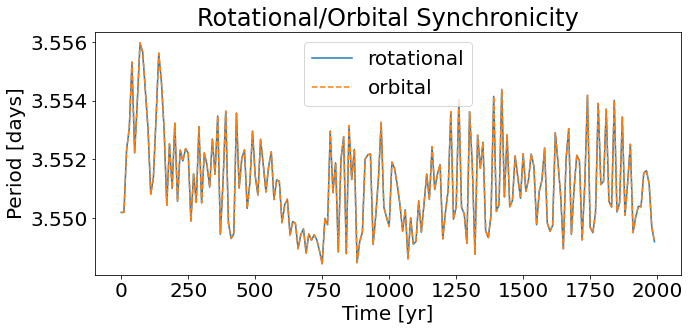

In [100]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=[10, 5], tight_layout=True)

ax.plot(time_range.value_in(units.yr), 1/(rot[0].value_in(units.day**-1)), label='rotational')   
ax.plot(time_range.value_in(units.yr), orb[0].value_in(units.day), ls='--', label='orbital')  
ax.set_title('Rotational/Orbital Synchronicity')
ax.set_ylabel('Period [days]')
ax.set_xlabel('Time [yr]')
ax.legend()

plt.show()

In [53]:
def plot_tracks(moons, ecc, inc, time_range, sma):
    
    plt.rcParams.update({'font.size': 20})
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[20, 15], tight_layout=True)
    colours = ['r', 'g', 'b', 'm']

    for i in range(len(moons)):
        ax1.plot(time_range.value_in(units.yr), inc[i].value_in(units.deg), color=colours[i], label=moons[i])   
    ax1.set_ylabel('Inclination [deg]')
    ax1.legend()

    for i in range(len(moons)):
        ax2.plot(time_range.value_in(units.yr), np.array(ecc[i]), color=colours[i], label=moons[i])   
    ax2.set_ylabel('Eccentricity')
    ax2.set_xlabel('Time [years]')
    ax2.legend()
    
    for i in range(len(moons)):
        ax3.plot(time_range.value_in(units.yr), sma[i].value_in(units.m), color=colours[i], label=moons[i])   
    ax3.set_ylabel('Semimajor Axis')
    ax3.set_xlabel('Time [years]')
    ax3.legend()
    
    plt.suptitle('Huayno Code (dt=10yrs)')
    plt.subplots_adjust(top=0.94)
    #plt.savefig('10000.png', facecolor='w', bbox_inches='tight')
    plt.show()

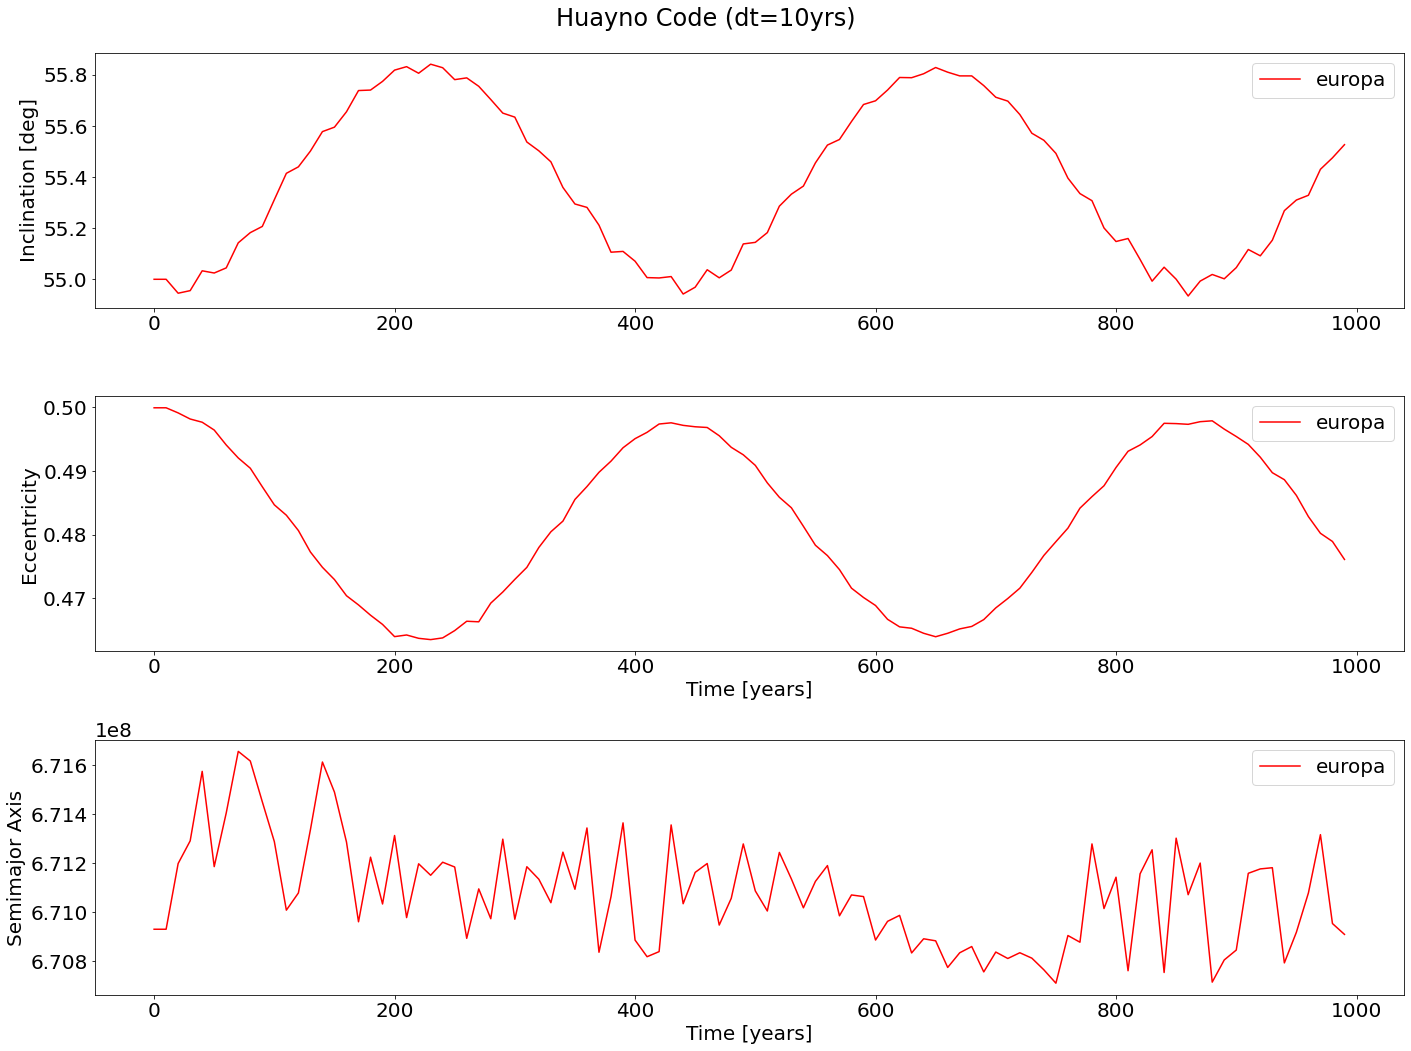

In [54]:
plot_tracks(moons, ecc, inc, time_range, sma)

In [11]:
''' The Kozai-constant Lz should be (approximately) conserved. This function will check this by computing Lz.
    Input: list of eccentricites and inclinations obtained from the integrate_system() function
    Returns: array of Lz's for each instance for each moon, and plots!
    Example: lz = check_lz(ecc, inc) '''
    
def check_lz(ecc, inc, moons):
    
    start_time = time.time()
    
    # Lz=sqrt(1-e**2)*cos(i)
    lz = np.zeros_like(ecc)
    for i in range(len(lz[0])):
        for j in range(len(lz[0:])):
            x = np.sqrt(1 - ecc[j][i]**2) * np.cos(inc[j][i].value_in(units.rad))
            lz[j][i] = x
    
    # Standard deviations
    sdev = []
    for i in range(len(lz[0:])):
        y = np.std(lz[i:])
        sdev.append(y)
    
    # Plotting
    colours = ['r', 'g', 'b', 'm']     
    plt.rcParams.update({'font.size': 20})
    
    # Sizes of subplots are annoying
    if len(lz[0:]) < 4:
        figsize=[10,8]
    else:
        figsize=[10,12]
    
    fig, ax = plt.subplots(len(lz[0:]), 1, figsize=figsize, constrained_layout=True)    
    
    for i, ax in enumerate(fig.axes):
        ax.plot(time_range.value_in(units.yr), lz[i], '-o', color=colours[i], lw=1, label=moons[i])
        ax.plot([], [], ' ', label='std = '+str(round(sdev[i],3)))
        ax.legend(fontsize=16) 
        
    plt.suptitle('Lz vs Time')
    #plt.subplots_adjust(top=0.94)
    plt.show()
    
    # Runtime
    print('Runtime: %s seconds' % (time.time() - start_time))
                           
    return lz

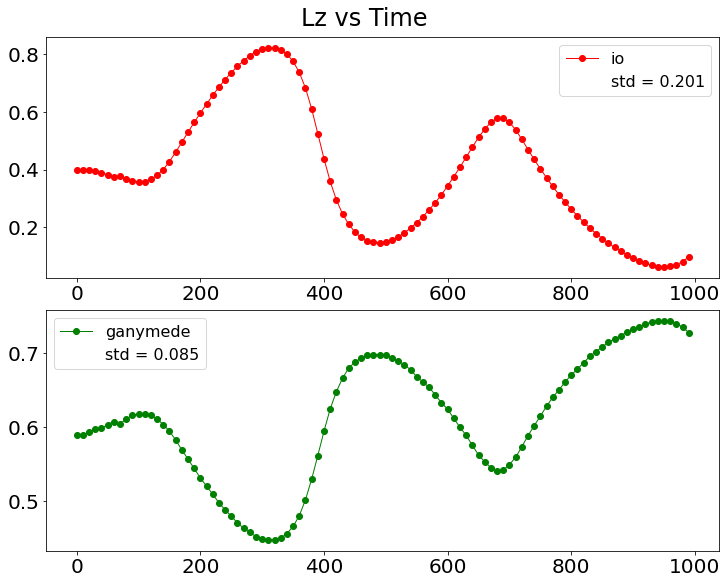

Runtime: 0.3038806915283203 seconds


In [13]:
lz = check_lz(ecc, inc, moons)

In [14]:
def plot_tidal_dissipation(td, time_range, moons):
    
    # Plotting
    colours = ['r', 'g', 'b', 'm']     
    plt.rcParams.update({'font.size': 20})
    
    # Sizes of subplots are annoying
    if len(td[0:]) < 4:
        figsize=[10,8]
    else:
        figsize=[10,12]
    
    fig, ax = plt.subplots(len(td[0:]), 1, figsize=figsize, constrained_layout=True)     
    
    for i, ax in enumerate(fig.axes):
        ax.plot(time_range.value_in(units.yr), td[i][:],'-o', color=colours[i], lw=1, label=moons[i])
        ax.legend(fontsize=16) 
        
    plt.suptitle('Tidal Dissipation vs Time')
    #plt.subplots_adjust(top=0.94)
    plt.show()

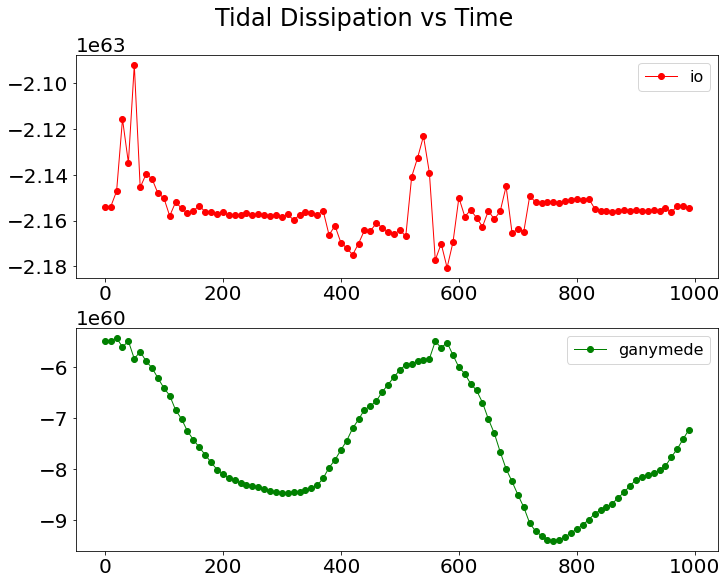

In [15]:
plot_tidal_dissipation(td, time_range, moons)